# **Домашнее задание 7.**

## **в этом ноутбуке ЧАСТЬ 2 домашнего задания:**

**Моя цель: >99.5 скора**



- Сначала я попробую разобраться с аугментацией, потому что это особо не было покрыто на семинарах (done)

- Затем я попробую хорошо зафайнтюнить сетку (done)

- Попробую организовать ансамбль из обученных сеток 

In [1]:
import torch
import numpy as np
import PIL
import random
import os
import time

train_on_gpu = torch.cuda.is_available()
train_on_gpu

False

In [2]:
def set_seed(seed):
    '''Делает наши результаты воспроизводимыми (вычисления могут немного больше времени занимать)'''
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip ./gdrive/MyDrive/simpsons.zip -d simpsons

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1037.jp

In [5]:
from torch.utils.data.dataset import ConcatDataset
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']       # сами объекты датасетов для train и val по своей структуре не будут отличаться, они оба размечены

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [7]:
class SimpsonsDataset(Dataset):
    """
    Класс датасета с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры

    Особенность нашего случая в том, что метки классов содержатся в названиях картинок, а не в
    отдельном цсв файле
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]     # извлекаем все возможные классы из названий картинок
            self.label_encoder.fit(self.labels)     # лейбл энкодер фитим на этих названиях классов

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)     # функция, позволяющая записывать объект в файл
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        ''' По пути к картинке возвращает PIL Image '''
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # Датасет у нас хранится в виде некоторых картинок, но как только мы достаем из него элемент с ним делается __getitem__
        transform = self.transform
        if transform is None:
            transform = transforms.Compose([
            transforms.ToTensor(),      # кстати totensor приводит итак все величины к от 0 до 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # видимо по каждому каналу уже были посчитаны
            ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')    # это вообще лишнее действие - оно в ToTensor делается, а с np.array плохо трансформации работают
        x = transform(x)
        if self.mode == 'test':
            return x        # если тестовый датасет, то возвращаем чисто тензор нормализованный по каналам
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()

            return x, y     # возвращает элемент датасета в виде нормализованного по каналам торч тензора и его метки
        
    def _prepare_sample(self, image):
        ''' рескейлит PIL Image '''
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
        # return image        # гораздо лучше PIL Image возвращать, потому что с ним все трансформации работают

In [8]:
# for kaggle:

# TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
# TEST_DIR = Path('../input/journey-springfield/testset/testset')

# for colab:

TRAIN_DIR = Path('./simpsons/train/simpsons_dataset')
TEST_DIR = Path('./simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))    # рекурсивно собирает все файлы из указанной директории формата jpg
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)
n_classes = len(np.unique(train_val_labels))

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode="test")

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    '''
    Функция обучения по всем батчам 1 раз (1 эпоха)
    '''
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    iter = 1
    start_time = time.time()
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

        # добавил, чтобы при запуске обучения видеть сколько примерно учиться
        if iter == 5:
            print(f'среднее время на одну итерацию: {round((time.time() - start_time) / 5, 4)}')
        iter += 1

    scheduler.step()
            
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_data, val_data, model, optimizer, scheduler, epochs, batch_size, save_path='/kaggle/working/model.pth'):
    '''
    Полный цикл обучения
    '''
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if val_acc > history[-1][-1]:      # Если качество на трейне и на валидации выросло, то сохраняем модельку
                    torch.save(model.state_dict(), save_path)

            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            
    return history

In [14]:
def predict(model, test_loader):
    ''' Возвращает предсказанные вероятности принадлежности к классу для переданного лоадера '''
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [15]:
from sklearn.metrics import f1_score
def get_f1_of_validation(model):

    imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]
    probs_ims = predict(model, imgs)        # predict - нам написанная функция (она софтмакс к выходам применяет)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]
    preds_class = [label_encoder.classes_[i] for i in y_pred]

    return f1_score(actual_labels, y_pred, average='micro')

In [16]:
import pandas as pd
def make_kaggle_submission(model, test_dataset, output_path='/kaggle/working/my_submission.csv'):
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)

    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))   # инверсивно трансформим из цифорок классов в string
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame()
    my_submit['Id'] = test_filenames
    my_submit['Expected'] = preds
    my_submit.to_csv(output_path, index=False)

In [17]:
def plot_history(history):
    '''
    history: list из tuple вида (train_loss, train_acc, val_loss, val_acc) по эпохам
    '''
    loss, acc, val_loss, val_acc = zip(*history)
    
    plt.figure(figsize=(12, 7))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.show()

полезная ссылка для fine tune inception v3
https://discuss.pytorch.org/t/why-auxiliary-logits-set-to-false-in-train-mode/40705

---
снизу пытаюсь разобраться с аугментацией
---

Займусь аугментацией данных, чтобы сделать обучающий датасет побольше, прежде чем обучать какие-то более сложные модели:

- необходимо создать датасет из трансформированных картинок, а потом его конктатенировать с оригинальным датасетом

In [18]:
from torchvision.utils import save_image

Код для работы с картинками, чтобы вообще понять: аугментировал я данные или нет

In [19]:
# Аугментация конечно же применяется только к обучающей выборке:

augm_transf_train = transforms.Compose([                                    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224 ,scale=(0.5, 1)),  # scale - min; max area of crop
    transforms.RandomRotation(20),
    transforms.GaussianBlur(9),     # чем больше ядро - тем суровее блюр очевидно
    # transforms.RandomPerspective(p=0.5),

    # не стоит пока делать преобразований яркости, поскольку тогда надо будет пересчитывать средние и отклонения по каналам
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                    
])

In [20]:
train_augm_dataset = SimpsonsDataset(train_files, mode='train', transform=augm_transf_train)

len(train_augm_dataset)

15699

In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

'abraham_grampa_simpson'

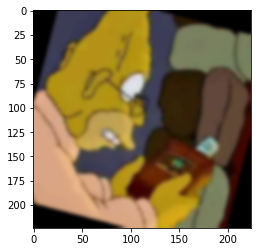

In [22]:
img, label = train_augm_dataset[95]
name = label_encoder.inverse_transform(np.array([label]))[0]

imshow(img)
name

**Сконкатенируем аугментированные данные и обычные данные:**

Думаю можно особо не париться, что картинки между датасетов объединенных не отшаффлены, поскольку даталоадер уже их отшаффлит, когда мы будем оттуда доставать батчи

In [23]:
new_train_dataset = ConcatDataset(
    [train_dataset, train_augm_dataset]
)       # ну, по сути это просто "объединение" двух классов, здесь нет ничего магического, а то я сначала не особо понял как это возможно

---

# Fine tuning VGG на новом большом датасете 

об архитектуре VGG:

```python
def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

```
---



In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [25]:
vgg_model = models.vgg11_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Что ж, займусь настройкой модели:

(Чтобы заморозить целый блок надо итерироваться по model.modules, например это актуально для inception_v3)

In [26]:
# average pool перед FC слоями не буду замораживать
unfreezed_layers = 5
for param in vgg_model.features[:-unfreezed_layers]:
    param.requires_grad = False
    # print(param.requires_grad)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою

FC_input_size = 25088
vgg_model.classifier = nn.Sequential(
            nn.Linear(FC_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes),
        )

# vgg_model.classifier = nn.Linear(FC_input_size, n_classes)

In [27]:
vgg_model.to(DEVICE)

RuntimeError: ignored

In [ ]:
optimizer = optim.Adam(vgg_model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0.02)

# exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
lmbda = lambda epoch: 0.9 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

31398

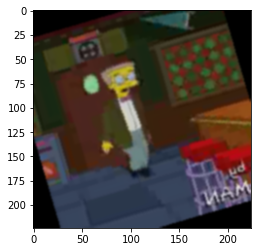

In [34]:
imshow(new_train_dataset[-100][0])
len(new_train_dataset)

In [ ]:
history = train(train_data=new_train_dataset,
                val_data=val_dataset,
                model=vgg_model,
                epochs=15, batch_size=16,
                scheduler=scheduler, optimizer=optimizer,
                save_path='./gdrive/MyDrive/vgg.pth')

In [ ]:
make_kaggle_submission(vgg_model, test_dataset, './1vgg_subm.csv')

- Результат был засабмичен: скор на кэггл: 0.98831

- Сейчас в планах: обучить efficient_net_b2 с batch_size=8 и уже получить желаемую точность в 99.5+